In [6]:
import os
import markovify
import numpy
import natsort
import matplotlib.pyplot as plt
text_folder = '../corpora/peregrine/'

seasons = {
    "oct" : "fall",
    "nov" : "fall",
    "dec" : "winter",
    "jan" : "winter",
    "feb" : "winter",
    "mar" : "spring",
    "apr" : "spring"
}

ss = 3

with open(text_folder+"/hidden/the-hunting-life.txt") as f:
    text = f.read()
    whole_model = markovify.Text(text, state_size=ss)

seasons_mark = {}
for season in seasons.values():
    with open(text_folder+"/hidden/seasons/"+season+".txt") as f:
        text = f.read()
        seasons_mark[season] = markovify.Text(text, state_size=ss)
    
with open(text_folder+"/hidden/first-lines.txt") as f:
    text = f.read()
    firstline_model = markovify.Text(text, state_size=ss)
    
def markovify(fn):
    import markovify
    with open(text_folder+fn) as f:
        txt = f.read()
        txt_model = markovify.Text(txt, state_size=ss)
    season_model = seasons_mark[seasons[fn[3:6]]]
    full_model = markovify.combine([whole_model, season_model,txt_model], [1,7,15])
    first_model = markovify.combine([firstline_model,txt_model],[5,1])
    new_text=""
    sd = sent_data(fn)
    num_sents = sd[1][4]
    max_len = sd[1][0]
    wc = sd[1][5]
    curlen = 0
    new = first_model.make_sentence(tries=400)
    if(new!=None):
            new_text+=(new+" ")
            curlen+=(new.count(" ")+1)
    while curlen<wc+5:
        #new = text_model.make_short_sentence(max_len)
        new = full_model.make_sentence(tries=500)
        if(new!=None):
            new_text+=(new+" ")
            curlen+=(new.count(" ")+1)
    m = open(text_folder+"_"+fn, "w+")
    m.write(new_text)
    m.close()

In [2]:
def sent_data(filename):
    import numpy
    sent_len = []
    with open(text_folder+filename) as f:
        text = f.read().strip("\n").split(".")
        text[0]+=" "
        for sent in text:
            if(sent!=""):
                sentlen = sent.count(" ")
                sent_len.append(sentlen)
        #max sent length, min sent length, mean sent length, standard deviation on sent length, number of sents, number of words
        data = [max(sent_len), min(sent_len),sum(sent_len)/len(sent_len), numpy.std(sent_len),len(sent_len), sum(sent_len)]
    return([sent_len,data])

In [3]:
def plot_sents(fn):
    max_x = sent_data(fn)[1][4]
    data = sent_data(fn)[0]
    plt.bar(range(1,max_x+1),data)

[38, 4, 15.192307692307692, 7.770849031769708, 52, 790]
[38, 1, 16.583333333333332, 7.390402935940338, 48, 796]


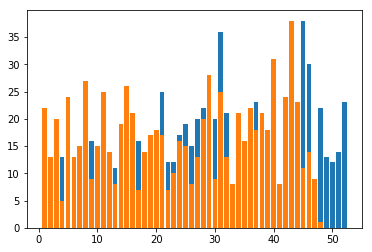

In [4]:
test_date = "42_dec-17.txt"
markovify(test_date)
print(sent_data(test_date)[1])
print(sent_data("_"+test_date)[1])
plot_sents(test_date)
plot_sents("_"+test_date)

In [5]:
for fn in os.listdir(text_folder):
    if(fn[0] not in ["_","-"] and fn[-3:]=="txt"):
        markovify(fn)

In [53]:
#creates the CSV metadata
dr=os.listdir(text_folder)
nr = natsort.natsorted(dr)
with open(text_folder+"peregrine.csv", "w+") as file:
    file.write("fn,season,author\n")
    for fn in nr:
        author="baker"
        month=fn[3:6]
        if(fn[-3:]=="txt"):
            if(fn[0]=="_"):
                author="markov"
                month = fn[4:7]
            elif(fn[0]=="-"):
                author="gpt-2"
                month = fn[4:7]
            file.write(fn+","+seasons[month]+","+author+"\n")
    file.close()
path_to_metadata='../corpora/peregrine/peregrine.csv'

In [54]:
# Get the metadata for this corpus
import pandas as pd
from textblob import TextBlob
pd.set_option("display.max_rows", 20)
import nltk

In [55]:
df_meta = pd.read_csv(path_to_metadata).set_index('fn')

In [56]:
def make_dtm(text_folder,normalize=False):

    # make an empty results list
    all_results = []
    
    columns=[]
    attrbs = ['max_sent_len','min_sent_len','mean_sent_len',
             'sd_sent_len','num_sents','num_words']
    columns.append('fn')
    for att in attrbs:
        columns.append(att)
    
    # for each filename
    filenames=sorted(os.listdir(text_folder))
    for fn in filenames:
        if(fn[-3:]=="txt"):
            text_result = {}
            text_result["fn"]=fn
            #max sent length, min sent length, mean sent length, standard deviation on sent length, number of sents, number of words
            text_result['max_sent_len']=sent_data(fn)[1][0]
            text_result['min_sent_len']=sent_data(fn)[1][1]
            text_result['mean_sent_len']=sent_data(fn)[1][2]
            text_result['sd_sent_len']=sent_data(fn)[1][3]
            text_result['num_sents']=sent_data(fn)[1][4]
            text_result['num_words']=sent_data(fn)[1][5]
        all_results.append(text_result)
            

    
    # Make dataframe
    df = pd.DataFrame(all_results, columns=columns).set_index('fn').fillna(0)
    
    # return dataframe
    return df

In [57]:
dtm = make_dtm(text_folder,normalize=True)

In [68]:
dtm_meta=df_meta.merge(dtm,on='fn')
dtm_meta = dtm_meta[dtm_meta.author !="gpt-2"]
dtm_meta

,season,author,max_sent_len,min_sent_len,mean_sent_len,sd_sent_len,num_sents,num_words
fn,,,,,,,,
00_oct-1.txt,fall,baker,28,2,13.213115,6.606293,61,806
01_oct-3.txt,fall,baker,20,2,10.000000,4.918694,31,310
02_oct-5.txt,fall,baker,38,3,14.309524,7.651605,42,601
03_oct-7.txt,fall,baker,44,2,15.488372,8.439586,43,666
04_oct-8.txt,fall,baker,18,2,10.888889,4.550811,36,392
05_oct-9.txt,fall,baker,26,2,13.000000,5.843189,28,364
06_oct-12.txt,fall,baker,26,4,14.035714,5.133797,56,786
07_oct-14.txt,fall,baker,26,4,10.000000,6.291757,29,290
08_oct-15.txt,fall,baker,37,3,17.185185,8.515942,27,464


In [76]:
print(dtm_meta.at["02_oct-5.txt","num_words"])

601


In [60]:
dtm_meta.groupby('author').mean()

,max_sent_len,min_sent_len,mean_sent_len,sd_sent_len,num_sents,num_words
author,,,,,,
baker,36.080460,3.885057,15.250972,7.412125,39.000000,591.367816
markov,34.640449,1.000000,17.054078,7.261573,35.842697,613.022472


author
baker     AxesSubplot(0.125,0.125;0.775x0.755)
markov    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mean_sent_len, dtype: object

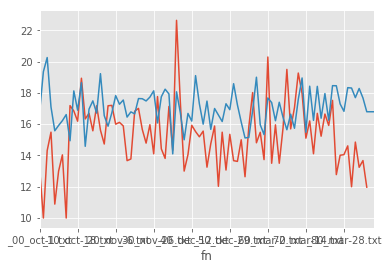

In [63]:
import matplotlib
matplotlib.style.use('ggplot')
dtm_meta.groupby('author').mean_sent_len.plot()